# Classifying on real data


In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import sys
import json
import matplotlib.pyplot as plt
from master_scripts.data_functions import *
from master_scripts.analysis_functions import *
from master_scripts.plotting import plot_event
%load_ext autoreload
%autoreload 2


## Data import

In [1]:
DATA_PATH = "../../data/real/anodedata_500k.txt"
DATA_FILENAME = "anodedata_500k.txt"
MODEL_PATH = "../../models/"
RESULTS_PATH = "../../results/"
CLASSIFIER = "4557cfeefc83.h5"

In [ ]:
# Load experiment and associated model (must be a saved model instance complete with weights)
experiment_id = "40350020681b"
experiment = load_experiment(experiment_id)
model = tf.keras.models.load_model(repo_root + "models/" + experiment_id + ".h5")
# Print experiment metrics
print("==== Experiment metrics")
print(json.dumps(experiment["metrics"], indent=2))
print("====")

In [8]:
events, images = import_real_data(DATA_PATH) # images not normalized
#images = normalize_image_data(images)

# load classification results (doesn't contain images)
with open(RESULTS_PATH + "events_classified_" + DATA_FILENAME[:-4] + "_" + CLASSIFIER[:-3] + ".json") as fp:
    events = json.load(fp)


In [9]:
descriptors = list([event['event_descriptor'] for event in events.values()])
print(descriptors.count(16))

17


# Results
## Plots
### Histogram of descriptor vs predicted class

## Preliminary results on anodedata_short.txt
|Event descriptor | Event type                   | singles | doubles |
| :---           |  :---:                       | :---:   | :---:   |
|        1        |           Implant            |  1743   |  87974  |
|        2        |            Decay             | 260147  |    0    |
|        4        |          Light ion           |  20537  | 128963  |
|        9        |   Implant + Double (time)    |    1    |    0    |
|       10        |    Decay + Double (time)     |   614   |    0    |
|       12        |  Light ion + Double (time)   |    3    |    0    |
|       16        |        Double (space)        |   11    |    6    |

## Results 05/08/20 anodedata_500k.txt
|Event descriptor | Event type                   | singles | doubles |
| :---           |  :---:                       | :---:   | :---:   |
|        1        |           Implant            |   904   |  88813  |
|        2        |            Decay             |  48613  | 211534  |
|        4        |          Light ion           |  3020   | 146480  |
|        9        |   Implant + Double (time)    |    0    |    1    |
|       10        |    Decay + Double (time)     |   206   |   408   |
|       12        |  Light ion + Double (time)   |    1    |    2    |
|       16        |        Double (space)        |    0    |   17    |



In [13]:
# Extract doubles
doubles = []
ion_double_t = []
for event_id, event in events.items():
    if event['event_descriptor'] == 16:
        doubles.append(event_id)
    if event['event_descriptor'] == 12:
        ion_double_t.append(event_id)

In [11]:
print(len(doubles))

17


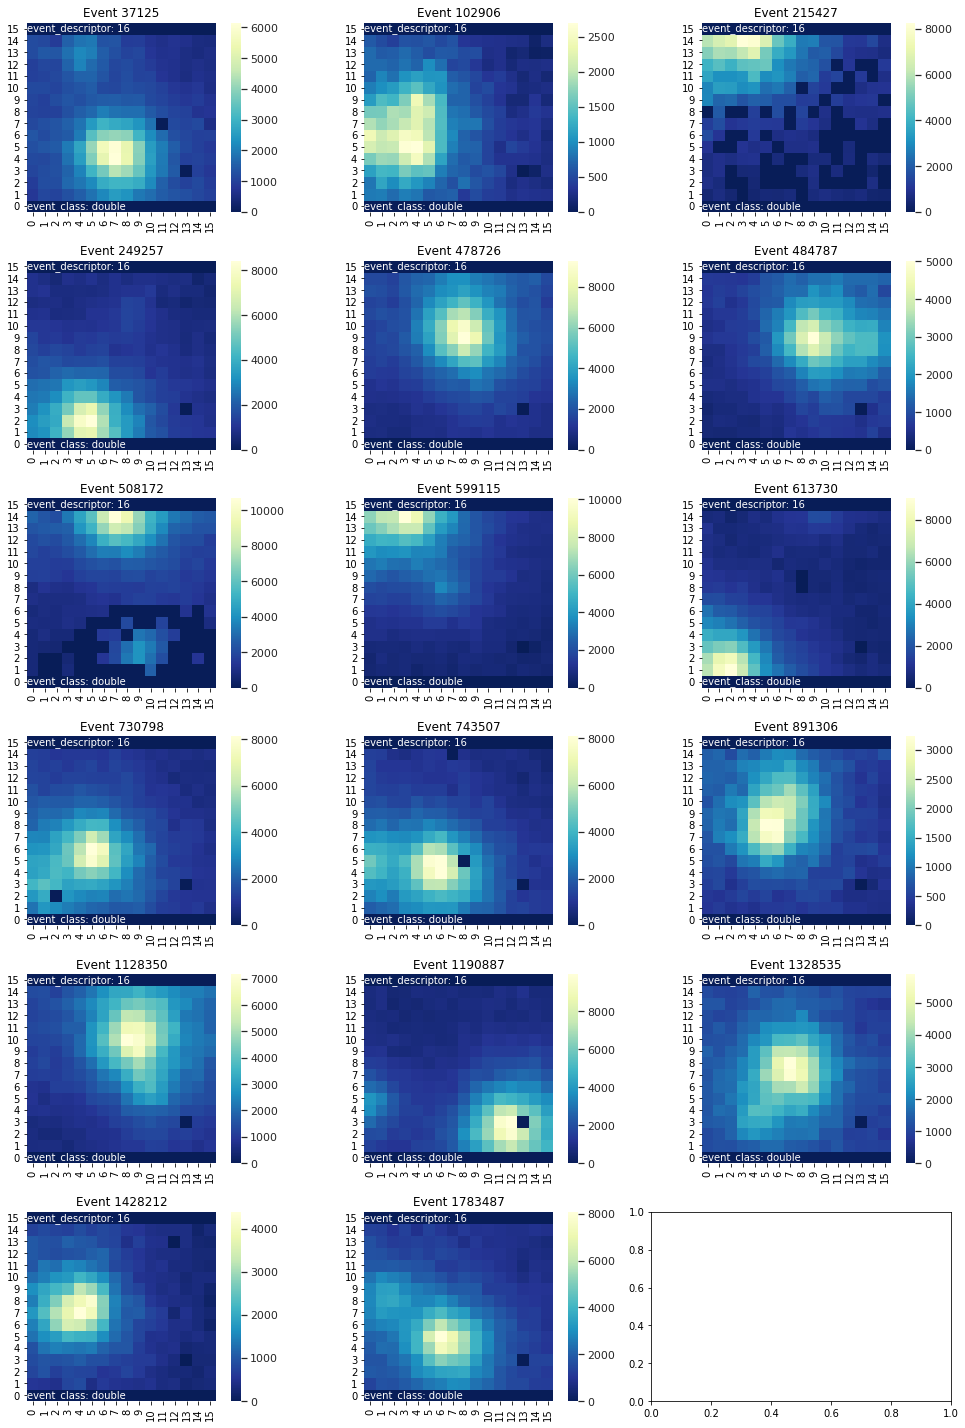

In [12]:
# Plot the doubles and event_class from model
fig, axes = plt.subplots(6,3, figsize=(14,20), tight_layout=True)
idx = 0
for row in axes:
    for ax_col in row:
        if idx >= len(doubles):
            break
        curr_event = events[doubles[idx]]
        plot_event(curr_event, doubles[idx], images[curr_event['image_idx']], ax_col)
        idx += 1
#fig.savefig("test.pdf")
    
    

## Plot doubles in time

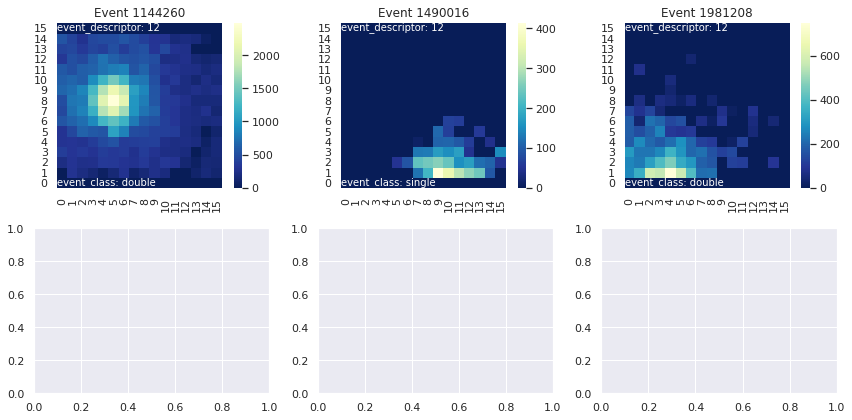

In [25]:
# Light ions + double (time)
fig, axes = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
idx = 0
for row in axes:
    for ax_col in row:
        if idx >= len(ion_double_t):
            break
        curr_event = events[ion_double_t[idx]]
        plot_event(curr_event, ion_double_t[idx], images[curr_event['image_idx']], ax_col)
        idx += 1
#fig.savefig("test.pdf")
    
    